***영수증(한글)에서 영수증이미지(객체)와 주변(배경)을 분리하는 것이 목적***

+ *Facebook AI Research에서 개발한 detectron2 활용*
+ *데이터셋은 Roboflow에 공개되어있는 영수증 데이터셋을 활용*

  + *https://universe.roboflow.com/receipt-segmentation/receipt-segmentation-jzoro/dataset/1*
   
  + *데이터셋 포맷: coco-segmentation*  

In [1]:
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.4 MB/s eta 0:00:00


### 1. Settings

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import os
import sys

base_dir = "/content/gdrive/MyDrive/Workspace/Colab"
sys.path.append(base_dir)

src_dir = os.path.join(base_dir, "ocr")
%cd $src_dir

dataset_dir = os.path.join(src_dir, "dataset/Roboflow/Receipt segmentation.v1i.coco-segmentation")

/content/gdrive/MyDrive/Workspace/Colab/ocr


In [4]:
!pip install -r requirements.txt > /dev/null



```
dataset/
├── Roboflow/
│   ├── Receipt segmentation.v1i.coco-segmentation/
│   │   ├── train/
│   │   │   ├── .jpg
│   │   │   └── _annotations.coco.json
│   │   ├── test/
│   │   │   ├── .jpg
│   │   │   └── _annotations.coco.json
│   │   └── valid/
│   │   │   ├── .jpg
│   │   │   └── _annotations.coco.json
│   └── ...
```



### 2. Detectron2 Mask RCNN 학습 및 평가

In [5]:
from detectron2.data.datasets import register_coco_instances

# COCO 형식의 데이터셋 등록 (=> DatasetCatalog에 등록)
register_coco_instances("coco_train", {}, f"{dataset_dir}/train/_annotations.coco.json", f"{dataset_dir}/train")
register_coco_instances("coco_test", {}, f"{dataset_dir}/test/_annotations.coco.json", f"{dataset_dir}/test")
register_coco_instances("coco_valid", {}, f"{dataset_dir}/valid/_annotations.coco.json", f"{dataset_dir}/valid")

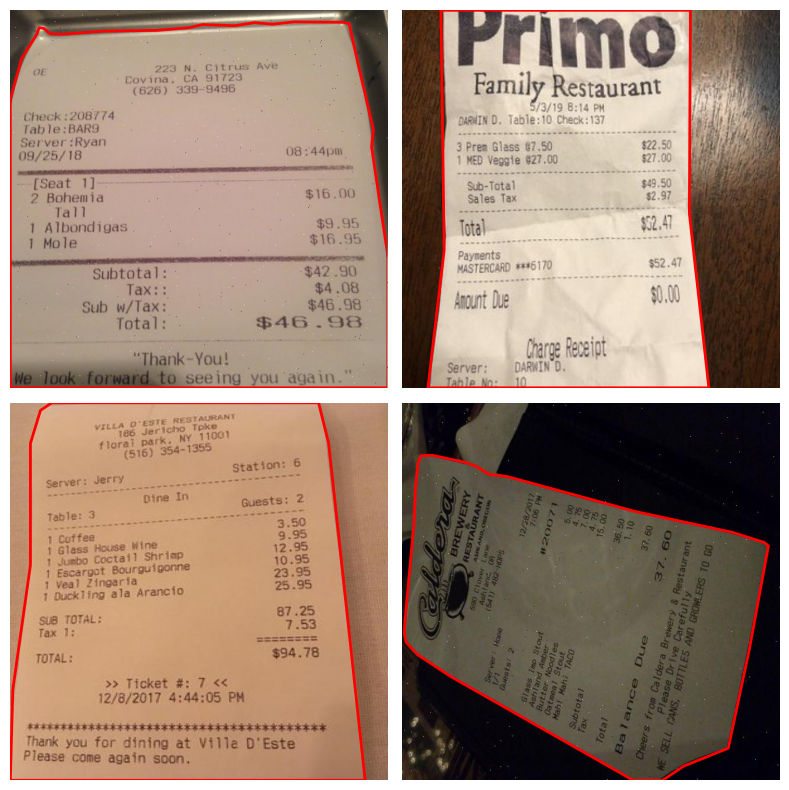

In [6]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog

# 등록된 학습데이터 불러오기
train_ds = DatasetCatalog.get("coco_train")

random_samples = random.sample(train_ds, 4)

# subplot 시각화
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, train_ds_dict in enumerate(random_samples):
    image = cv2.imread(train_ds_dict["file_name"])
    ax = axes[i // 2, i % 2]

    for ann in train_ds_dict['annotations']:

        for poly in ann['segmentation']:
            x = poly[0::2]
            y = poly[1::2]
            ax.plot(x, y, linewidth=2, color='red')

    ax.imshow(image[:, :, ::-1])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [7]:
category_ids = set()

# category_id 추출
for entry in train_ds:

    for ann in entry['annotations']:
        category_ids.add(ann['category_id'])

print(f"Unique category IDs count: {len(category_ids)}")

Unique category IDs count: 1


*해당 카테고리에 속한 객체가 없는데 정의되어있는 의미없는 카테고리 제거함 (수동)*

---

*(기존) _annotations.coco.json*

```
"categories": [
    {"id": 0, "name": "receipt-xGa7", "supercategory": "none"},
    {"id": 1, "name": "receipt", "supercategory": "receipt-xGa7"}
]
```

*(수정) _annotations.coco.json*

```
"categories": [
    {"id": 1, "name": "receipt", "supercategory": "none"}
]
```



In [8]:
from detectron2 import model_zoo
from detectron2.config import get_cfg

# config 설정
cfg = get_cfg()

# 모델 설정 불러와 cfg에 설정 (Mask R-CNN 모델)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

# 데이터셋 설정
cfg.DATASETS.TRAIN = ("coco_train",)
cfg.DATASETS.VALID = ("coco_valid",)
cfg.DATASETS.TEST = ("coco_test",)

# Dataloader에 사용될 Worker 수
cfg.DATALOADER.NUM_WORKERS = 2

# Pre-trained된 모델의 가중치
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

# Train 관련 설정
cfg.SOLVER.IMS_PER_BATCH = 2   # 각 훈련 스텝에서 처리할 이미지 수 (batch size)
cfg.SOLVER.BASE_LR = 0.00025   # 초기 학습률 설정
cfg.SOLVER.MAX_ITER = 3000     # 총 훈련 반복 횟수
cfg.SOLVER.STEPS = []          # 학습률 감소를 위한 스텝 설정

# ROI 헤드 설정
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# 모델 평가 주기 설정
cfg.TEST.EVAL_PERIOD = 0  # 0 이면, 사용 X

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)  # 디폴트; ./output

*mask_rcnn_R_101_FPN_3x.yaml --> ResNet-101 기반의 FPN모델*

In [ ]:
from detectron2.engine import DefaultTrainer

# Train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/10 07:55:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:01, 171MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/10 07:55:25 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/10 07:55:39 d2.utils.events]:  eta: 0:23:17  iter: 19  total_loss: 2.052  loss_cls: 1.251  loss_box_reg: 0.08841  loss_mask: 0.6992  loss_rpn_cls: 0.0008411  loss_rpn_loc: 0.007099    time: 0.4731  last_time: 0.5545  data_time: 0.0328  last_data_time: 0.0171   lr: 4.9953e-06  max_mem: 2419M
[01/10 07:55:55 d2.utils.events]:  eta: 0:23:29  iter: 39  total_loss: 1.737  loss_cls: 1.013  loss_box_reg: 0.07944  loss_mask: 0.6229  loss_rpn_cls: 0.002334  loss_rpn_loc: 0.008132    time: 0.4850  last_time: 0.5018  data_time: 0.0124  last_data_time: 0.0160   lr: 9.9902e-06  max_mem: 2421M
[01/10 07:56:05 d2.utils.events]:  eta: 0:22:36  iter: 59  total_loss: 1.23  loss_cls: 0.6494  loss_box_reg: 0.07716  loss_mask: 0.4845  loss_rpn_cls: 0.001286  loss_rpn_loc: 0.007549    time: 0.4763  last_time: 0.4709  data_time: 0.0070  last_data_time: 0.0127   lr: 1.4985e-05  max_mem: 2421M
[01/10 07:56:14 d2.utils.events]:  eta: 0:22:27  iter: 79  total_loss: 0.8296  loss_cls: 0.3327  loss_box_reg: 0.0

In [ ]:
from detectron2.evaluation import COCOEvaluator

# 평가
evaluator = COCOEvaluator("coco_test", cfg, False, output_dir="./output/")
trainer.test(cfg, trainer.model, evaluators=[evaluator])

WARNING [01/10 08:21:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/10 08:21:15 d2.data.datasets.coco]: Loaded 36 images in COCO format from /content/gdrive/MyDrive/Workspace/Colab/ocr/dataset/Roboflow/Receipt segmentation.v1i.coco-segmentation/test/_annotations.coco.json
[01/10 08:21:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/10 08:21:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/10 08:21:15 d2.data.common]: Serializing 36 elements to byte tensors and concatenating them all ...
[01/10 08:21:15 d2.data.common]: Serialized dataset takes 0.02 MiB
[01/10 08:21:15 d2.evaluation.evaluator]: Start inference on 36 batches
[01/10 08:21:17 d2.evaluation.evaluator]: Inference done 11/36. Dataloading: 0.05

OrderedDict([('bbox',
              {'AP': 93.27226231750964,
               'AP50': 95.64356435643565,
               'AP75': 92.71986022131625,
               'APs': nan,
               'APm': nan,
               'APl': 93.27226231750964}),
             ('segm',
              {'AP': 92.17598189839268,
               'AP50': 95.64356435643565,
               'AP75': 92.71986022131625,
               'APs': nan,
               'APm': nan,
               'APl': 92.17598189839268})])

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

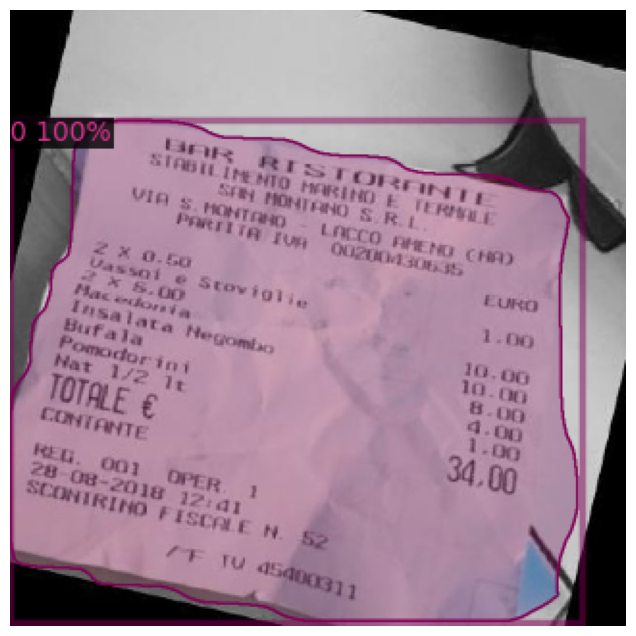

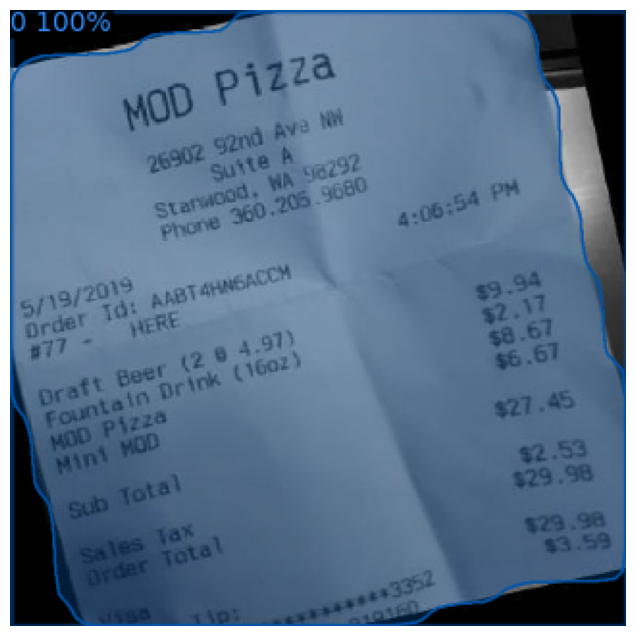

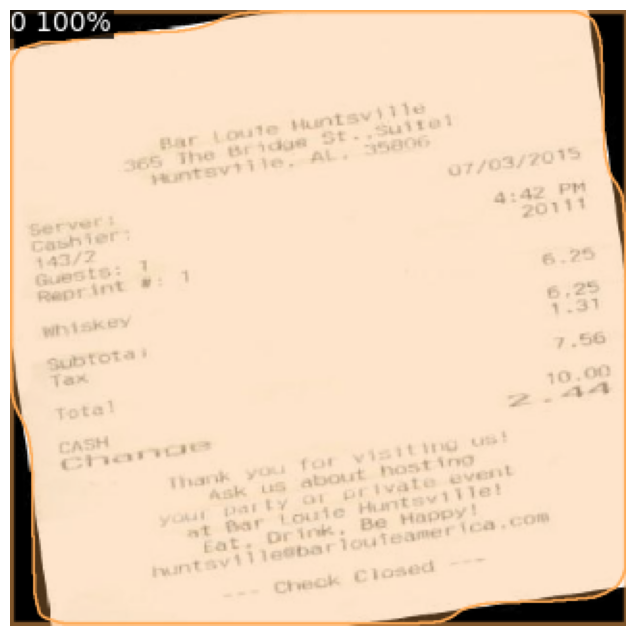

In [9]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# 추론
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
predictor = DefaultPredictor(cfg)

# 시각화
val_ds = DatasetCatalog.get("coco_test")

for d in random.sample(val_ds, 3):
    image = cv2.imread(d["file_name"])
    outputs = predictor(image)
    v = Visualizer(image[:, :, ::-1],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(8, 8))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

### 3. 새로운 영수증(이미지) 적용 결과 확인

In [10]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()
for file_name, file_content in uploaded.items():
    print(f"File name: {file_name}")

image_files = list(uploaded.keys())

Saving Offline.jpg to Offline (1).jpg
File name: Offline (1).jpg


In [11]:
image = cv2.imread(image_files[0])
print(f"이미지 크기: {image.shape[:2]}")

이미지 크기: (4032, 3024)


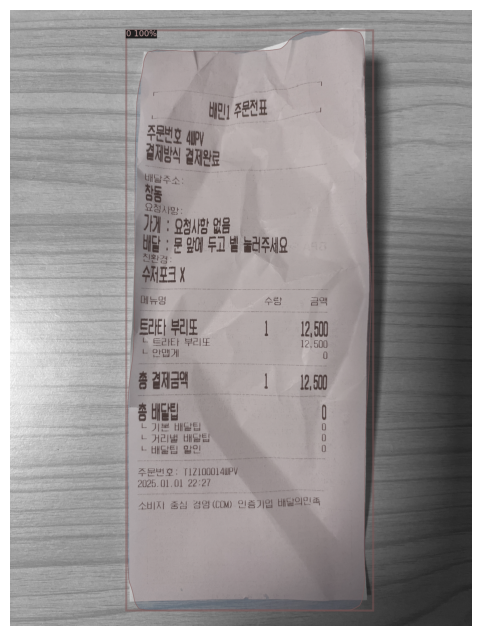

In [12]:
output = predictor(image)

v = Visualizer(
    image[:, :, ::-1],
    scale=0.5,
    instance_mode=ColorMode.IMAGE_BW
)

out = v.draw_instance_predictions(output["instances"].to("cpu"))

plt.figure(figsize=(8, 8))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

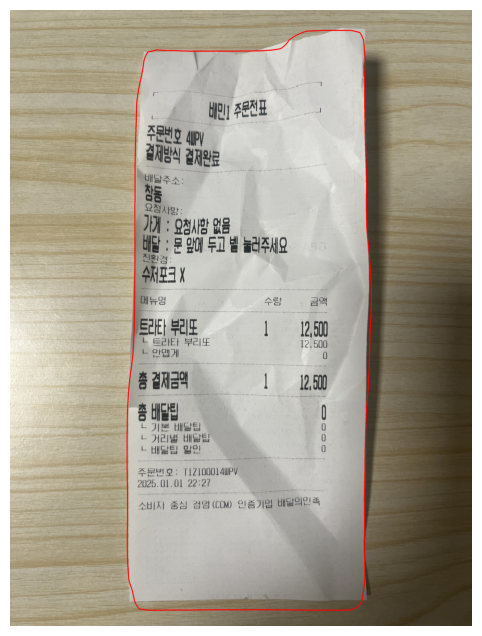

In [13]:
# 윤곽선만
instances = output["instances"].to("cpu")
masks = instances.pred_masks.numpy()

canvas = image[:, :, ::-1].copy()
for mask in masks:
    contours, _ = cv2.findContours(
        mask.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    cv2.drawContours(canvas, contours, -1, (255, 0, 0), thickness=5)

plt.figure(figsize=(8, 8))
plt.imshow(canvas)
plt.axis("off")
plt.show()

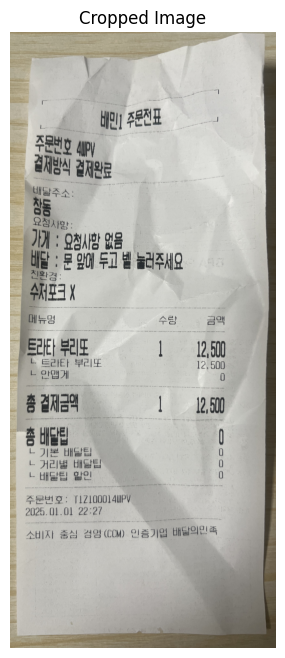

In [14]:
# bbox 기준, 이미지 Crop (윤각선으로 하면 그림이 좀 각지지않음)
instances = output["instances"].to("cpu")
boxes = instances.pred_boxes.tensor.numpy()

x1, y1, x2, y2 = boxes[0]

margin = 20
x_start = max(int(x1) - margin, 0)
y_start = max(int(y1) - margin, 0)
x_end = min(int(x2) + margin, image.shape[1])
y_end = min(int(y2) + margin, image.shape[0])

# bbox 기준, Crop
cropped_image = image[y_start:y_end, x_start:x_end]

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Cropped Image")
plt.show()

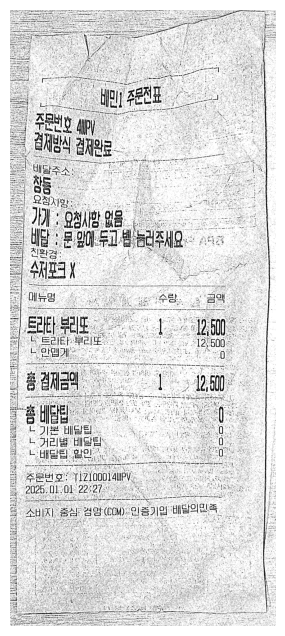

In [16]:
from skimage.filters import threshold_local

gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
T = threshold_local(gray, 21, offset = 5, method = "gaussian")

cropped_image_processing = (gray > T).astype("uint8") * 255

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(cropped_image_processing, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

*OCR 모델에 넣기전에, 데이터 전처리 (윤곽선 기반으로 주변 배경 없애거나, 등등)*